[코드 10.2.1]

In [ ]:
# prerequisites
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 256
image_size = 784
num_epochs = 10
BATCH_SIZE = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader
torch.manual_seed(0)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

D.to(device)
G.to(device)

# loss function
loss_function = nn.BCELoss()

# optimizer
learning_rate = 0.0002
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

D_loss_epochs, G_loss_epochs = [], []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

        # ======================================================== #
        #                      Train the discriminator             #
        # ======================================================== #

        outputs = D(images)
        D_loss_real = loss_function(outputs, real_labels)

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(BATCH_SIZE, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        D_loss_fake = loss_function(outputs, fake_labels)

        # Backprop and optimize
        D_loss = D_loss_real + D_loss_fake
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # ========================================================= #
        #                        Train the generator                #
        # ========================================================= #

        # Compute loss with fake images
        z = torch.randn(BATCH_SIZE, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        G_loss = loss_function(outputs, real_labels)

        # Backprop and optimize
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

    D_loss_epochs.append(D_loss.mean().item())
    G_loss_epochs.append(G_loss.mean().item())

    print('Epoch [%d/%d]: D_loss: %.4f, G_loss: %.4f' % (epoch, num_epochs, D_loss.mean().item(), G_loss.mean().item()))

#    print('Epoch [%d/%d]: D_loss: %.4f, G_loss: %.4f' % (epoch, num_epochs, torch.mean(torch.FloatTensor(D_loss)),
#                                                   torch.mean(torch.FloatTensor(G_loss))))
    # real image 저장
    if (epoch+1) == num_epochs:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image((images+1)/2, os.path.join('./mnist_data/', 'real_images.png'))

    # 생성된 이미지 저장
    if epoch==0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image((fake_images+1)/2, os.path.join('./mnist_data/', 'fake_images-{}.png'.format(epoch+1)))

    if (epoch+1) % 10==0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image((fake_images+1)/2, os.path.join('./mnist_data/', 'fake_images-{}.png'.format(epoch+1)))

100%|██████████| 9912422/9912422 [00:00<00:00, 40534778.14it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36796990.83it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 16725736.65it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16565677.19it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Epoch [0/10]: D_loss: 0.0326, G_loss: 5.5315
Epoch [1/10]: D_loss: 0.0312, G_loss: 6.1597
Epoch [2/10]: D_loss: 0.7214, G_loss: 3.9685
Epoch [3/10]: D_loss: 0.4644, G_loss: 2.8068
Epoch [4/10]: D_loss: 1.0929, G_loss: 2.9090
Epoch [5/10]: D_loss: 0.1776, G_loss: 3.6615
Epoch [6/10]: D_loss: 0.0485, G_loss: 4.4963
Epoch [7/10]: D_loss: 0.1182, G_loss: 4.7949
Epoch [8/10]: D_loss: 0.0529, G_loss: 4.9178
Epoch [9/10]: D_loss: 0.0543, G_loss: 7.7803


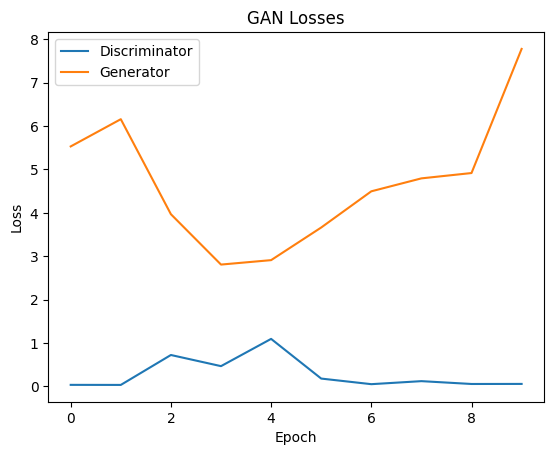

In [ ]:
import matplotlib.pyplot as plt

plt.plot(D_loss_epochs, '-')
plt.plot(G_loss_epochs, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('GAN Losses');